<h1 align="center">CS340 - Assignment 1</h1>
<h3 align="center">Due Date: 27 March 2017</h3>
<p style="text-indent: 40px">In this project we are going to simulate a hypothetical situation with <b>Spark</b>. Let's say we have 100x100 board similar to the bord above. A million times we throw three stones to the board.</p>

<div>
    <img src="http://image.prntscr.com/image/c577048a6cdf405990621e5b24bc1ade.png" width=200>

    <center><strong>Figure 1: 18x18 board</strong></center>
</div>

## Triangle or Not

<p style="text-indent: 40px">For the first part of this assignment you should calculate, out of those one million trials how many of them could form a triangle. The data is included in the assignment folder. Each row in the data represents a triangle and structure is like  "x1 y1, x2 y2, x3 y3" where x's and y's are the coordinates of the edges.</p>


<p style="text-indent: 40px"> Note: To check if a triangle is valid or not you should use <b>triangle inequality theorem</b>.</p>
<p style="text-indent: 40px"> Caution: Do not use loops or externmal libraries, you should only use <b>Spark</b>. Only library you can use for this project is matplotlib.</p>
<p style="text-indent: 40px">Important: <b>Plagiarism</b> will not be tolerated and issue will be referred to the <b>disciplinary committee</b>.</p>

In [1]:
# The code was removed by DSX for sharing.

In [2]:
data = sc.textFile("swift://CS340." + name + "/triangles.csv", 8).cache()

In [3]:
def length(a, b):
     return((a[0] - b[0])**2 + (a[1] - b[1])**2)**0.5

def isValid(A, B, C):
    c = length(A, B)
    b = length(A, C)
    a = length(C, B)
    return ((a + b > c) and (a + c > b) and (b + c > a))


triangles_id = data.map(lambda x: tuple(x.split(",")))\
    .map(lambda (x,y,z): (x.split(), y.split(), z.split()))\
    .map(lambda x: [[int(el) for el in li] for li in x])\
    .filter(lambda x: isValid(*x))\
    .zipWithUniqueId()

In [4]:
print("valid triengle count: " + str(triangles_id.count()))

valid triengle count: 999074


## Number of Neighbours
<p style="text-indent: 40px">For the next part of this project, you sohuld get the number of neighbours that each triangle(only valid traingles) has. Draw a histogram from those numbers with matplotlib library, number of bins shuld be 100 for the histogram. Then you should calculate the mean of the number of neighbours with <b>Spark</b>.</p>

<p style="text-indent: 40px"> For the simplicity, let's say that, if two triangles has a common vertex, they are neighbour.</p> 

In [5]:
# check for each triangle that how many triangele it connects to

        
point_id = triangles_id.flatMap(lambda (triangle, index): [(tuple(point), index) for point in triangle])

point_ids = point_id.groupByKey().mapValues(lambda x : set(x))

id_neighs = point_id.join(point_ids)\
        .map(lambda (point, (triange_id, triange_ids)): (triange_id, triange_ids))\
        .groupByKey()\
        .mapValues(lambda sets: len(set.union(*sets))-1).cache()

In [6]:
num_of_neigs = id_neighs.map(lambda (x,y): y)

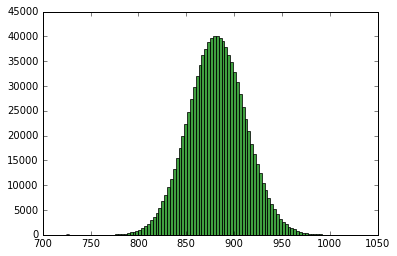

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(num_of_neigs.collect(), 100, facecolor='green', color='green', alpha=0.75)
plt.show()

In [8]:
# mean
print num_of_neigs.reduce(lambda x,y : x+y) / float(num_of_neigs.count())

881.316344935


## Circumferences

<p style="text-indent: 40px">For the next part of this project you should calculate the circumferences of the triangles(only valid traingles). Then you should draw a <b>scatter plot</b> of "circumferences" and "number of neighbours". One caveat is that one million point is too much to draw, so take only ten thousand trianges that has the largest circumferences.</p>

In [10]:
def calcCircumference(A, B, C):
    c = length(A, B)
    b = length(A, C)
    a = length(C, B)
    return a + b + c

id_circumferences = triangles_id.map(lambda (triangle, id): (id, calcCircumference(*triangle)))


In [11]:
_sorted = id_circumferences.join(id_neighs, 8).map(lambda (x,y): y).sortBy(lambda x: x[0])
x = _sorted.map(lambda x : x[0]).take(10000)
y = _sorted.map(lambda x : x[1]).take(10000)

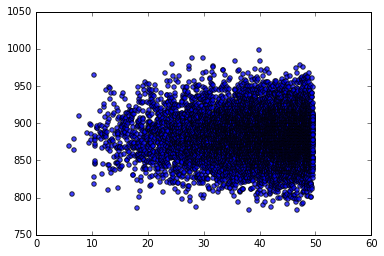

In [12]:
import numpy as np
colors = np.random.rand(10)

plt.scatter(x, y, alpha=0.75)
plt.show()